In [1]:
import pandas as pd
import sklearn
import numpy as np
import os
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import lightgbm as lgbm
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import scipy.stats
from sklearn.preprocessing import FunctionTransformer
from scipy.stats.mstats import winsorize 

pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("whitegrid")

In [2]:
%%time
#get data
datasets = r'Input'
output = r'Output'

df = pd.read_excel(os.path.join(datasets,r'data_set_CB_2022 (1).xlsx'))

Wall time: 57.8 s


# Overview
We have a dataset of customers, with the idea of understanding the profile of those who buy a specific product and then create a predictive model to be able to target these customers.

This notebook will be divided into the following steps:

1) Exploratory data analysis to build a "profile" for our customers and unsderstand the data

2) Feature engineering to prepare the data for our propensity scoring model

3) Build the model

In the first step, we will do a first analysis of the data, without going too much in detail to avoid the "data snooping" bias. We will build an analytical dataframe (DF), checking for missing values and get a first sense of the distribution. Then we will dig deeper, for instance looking at correlations with target variable.

In the second step, we will work on feature engineering & model training to predict the target variables. Training will be done with cross validation, scoring first in the out-of-fold portion of the data, then on a holdout set.

Upon having chosen the best model(s), we will apply them in the 3rd step to predict the response variable.

### 1) EDA
Let's start with getting an overview of the data. We'll look at a few things:
- missing / fishy values
- the distributions of the variables (to see if we'll need scaling or if anything is odd)
- the distributions of the variables, segmenting for the target variable (does any of the features behave oddly compared vs the target?)

We have a total of 165,796 records, coming from 87,293 records in our dataset.

At first sight there'd be very few missing values only in the "REVENU_MOYEN" feature, but we know that operators missing a loyalty card have "0" as ID - and we only have 55k records with that as ID. In total, we have 166k IDs, meaning that ~110k "identified" records come from 87k unique known customers.

We can therefore understand that we have records at the "order level": each record is the purchase of a product by a customer (identified or otherwise), with extra info.

One key question is therefore what to do with "unidentified" customers. They represent around a thirdo of our data, so a lot, but to use them properly we'd have to build them an ID (e.g. considering unique combinations of ID 0 and the other features). Let's keep this in mind for later.

In [3]:
df.head()

,HH_ID,QUARTIER,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,FAM_GRP_CD,AVERAGE_AGE_HH,DEBIT,CHIFFRE_AFFAIRE
0,4859378284,13008A030,"28,371.00",1,5499,A,33,5,41.57
1,0,44021A02-,"32,245.00",1,2220,B,35,3,3.51
2,5587586,11009C00-,"36,406.00",4,6396,A,49,21,144.08
3,668254,52022A29-,"29,271.00",2,1877,D,66,1,2.26
4,6352173,42025A201,"29,350.00",4,6912,B,44,2,5.70


In [4]:
df.shape

(165796, 9)

In [5]:
df['HH_ID'].nunique()

87293

In [6]:
df['HH_ID'].value_counts()

0             55416
1087810           6
7197578           4
3287454           4
2655293338        4
              ...  
3238960204        1
2414658           1
1981467718        1
6484658782        1
1802466           1
Name: HH_ID, Length: 87293, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165796 entries, 0 to 165795
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   HH_ID            165796 non-null  int64  
 1   QUARTIER         165796 non-null  object 
 2   REVENU_MOYEN     157502 non-null  float64
 3   NBRE_HABITANT    165796 non-null  int64  
 4   POINTS_LOYALTY   165796 non-null  int64  
 5   FAM_GRP_CD       165796 non-null  object 
 6   AVERAGE_AGE_HH   165796 non-null  int64  
 7   DEBIT            165796 non-null  int64  
 8   CHIFFRE_AFFAIRE  165796 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 11.4+ MB


In [8]:
#we have many unique values in quartier, as well as quite a few missing (!) ones
#some records have "0" as revenu moyen, which is odd but not impossible
#nothing exceedingly out of the ordinary for the other fields

print(df['QUARTIER'].value_counts())
print('')
print(df['REVENU_MOYEN'].value_counts())
print('')
print(df['POINTS_LOYALTY'].value_counts())
print('')
print(df['FAM_GRP_CD'].value_counts())
print('')
print(df['NBRE_HABITANT'].value_counts())
print('')
print(df['AVERAGE_AGE_HH'].value_counts())
print('')
print(df['DEBIT'].value_counts())
print('')
print(df['CHIFFRE_AFFAIRE'].value_counts())

?????????    8294
11013A101     245
62063A401     243
21016A82-     220
21009A33-     197
             ... 
42025A091       1
81015D001       1
42006E042       1
11024B00-       1
53070D072       1
Name: QUARTIER, Length: 12702, dtype: int64

0.00         616
34,262.00    247
38,239.00    245
27,841.00    243
29,690.00    223
            ... 
41,949.00      1
24,487.00      1
20,368.00      1
21,945.00      1
29,827.00      1
Name: REVENU_MOYEN, Length: 9758, dtype: int64

514      138
446      124
508      123
488      118
504      118
        ... 
23863      1
9944       1
37560      1
14580      1
7398       1
Name: POINTS_LOYALTY, Length: 12172, dtype: int64

A    66622
B    66550
D    18565
C    14059
Name: FAM_GRP_CD, dtype: int64

1     52274
2     50371
4     20263
3     19496
5      8929
0      5666
6      5314
7      1940
8       966
9       288
10      153
11       73
12       45
13       13
15        4
14        1
Name: NBRE_HABITANT, dtype: int64

0      5779
40     4190
4

In [9]:
#quick duplicate IDs check to see if we can use that field as index

iddups = df[df['HH_ID'].duplicated()].shape[0]

if iddups == 0:
    print('no duplicate in ID columns, ok to use as index')
else:
    raise Warning('duplicates in ID columns')


Warning: duplicates in ID columns

In [10]:
#let's create a df to "be processed"
df_proc = df.copy(deep=True)
#let's cast missing quartier as null
df_proc.loc[df_proc['QUARTIER'] == '?????????', 'QUARTIER'] = np.NaN

In [11]:
#let's look at the distribution of values for "identified" and "unidentified" customers
#hypothesis: it is unidenfitied custoemrs who have odd values for HH size and age
df_proc.describe()

,HH_ID,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,DEBIT,CHIFFRE_AFFAIRE
count,"165,796.00","157,502.00","165,796.00","165,796.00","165,796.00","165,796.00","165,796.00"
mean,"1,372,014,768.72","30,951.62",2.39,"2,995.11",48.81,1.94,12.03
std,"2,246,182,685.54","7,415.18",1.62,"5,571.24",18.21,2.26,23.95
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,0.00,"26,141.00",1.00,598.00,37.00,1.00,2.17
50%,"2,514,367.00","30,209.00",2.00,"1,415.00",48.00,1.00,4.80
75%,"3,235,380,941.00","34,872.00",3.00,"3,227.00",61.00,2.00,11.50
max,"6,490,963,524.00","93,770.00",15.00,"240,349.00",135.00,63.00,"1,113.14"


In [12]:
#unfortunately, our hypotesis is disproven: identified cust
df_proc[df_proc['HH_ID'] != 0].describe()

,HH_ID,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,DEBIT,CHIFFRE_AFFAIRE
count,"110,380.00","104,789.00","110,380.00","110,380.00","110,380.00","110,380.00","110,380.00"
mean,"2,060,831,315.41","30,947.58",2.39,"3,003.29",48.76,1.93,12.00
std,"2,481,695,096.16","7,421.10",1.62,"5,593.17",18.24,2.26,24.02
min,111.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,"2,525,767.00","26,126.00",1.00,599.00,37.00,1.00,2.17
50%,"15,244,268.00","30,197.00",2.00,"1,418.00",48.00,1.00,4.81
75%,"3,240,230,264.00","34,872.00",3.00,"3,233.00",61.00,2.00,11.39
max,"6,490,963,524.00","93,770.00",15.00,"240,349.00",135.00,60.00,"1,113.14"


In [13]:
#only 8% of the sample bought product category C: we'll have to deal with the rare class problem

df_proc['FAM_GRP_CD'].value_counts() / df.shape[0]

A   0.40
B   0.40
D   0.11
C   0.08
Name: FAM_GRP_CD, dtype: float64

In [14]:
#let's see all columns with missing values 

def missing_values(data):
    total = []
    percent = []
    types = []
    
    for col in data.columns:
            total.append(data[data[col].isnull()].shape[0])
            percent.append((data[data[col].isnull()].shape[0]/data.shape[0]))
            types.append(str(data[col].dtype)) 

    total = pd.Series(total)
    percent = pd.Series(percent)
    types = pd.Series(types)        
    tt = pd.concat([total, percent, types], axis=1, keys=['Total', 'Percent', 'Type'])
    tt = tt[tt['Total'] > 0]
    tt = np.transpose(tt)
    tt.columns = data.iloc[:, tt.columns].columns
    return(tt)

In [15]:
#we have two columns with missing values, very few rows impacted
nas = missing_values(df_proc)
nas

,QUARTIER,REVENU_MOYEN
Total,8294,8294
Percent,0.05,0.05
Type,object,float64


Since these missing values are very few and relate in good part to the target variable, the right thing to do is to remove them.
We'll have to keep this in mind when preparing the dataframe

In [16]:
%%time

#let's see most fequent/duplicate values per field

features = df_proc.columns.values
unique_max_train = []

for feature in features:
    values = df_proc[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax(), str(df_proc[feature].dtype)])
    
dups = np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value', 'Type'])).\
                sort_values(by = 'Max duplicates', ascending=False)).T           

Wall time: 137 ms


In [17]:
dups

,Feature,Max duplicates,Value,Type
7,DEBIT,102442,1,int64
5,FAM_GRP_CD,66622,A,object
0,HH_ID,55416,0,int64
3,NBRE_HABITANT,52274,1,int64
6,AVERAGE_AGE_HH,5779,0,int64
8,CHIFFRE_AFFAIRE,2329,0.99,float64
2,REVENU_MOYEN,616,0.00,float64
1,QUARTIER,245,11013A101,object
4,POINTS_LOYALTY,138,514,int64


In [18]:
#let's see if other fields contain fishy "!" data 

def fishy_values(data):
    total = []
    percent = []
    types = []
    
    for col in data.columns:
            total.append(data[data[col].astype(str).str.contains('!')].shape[0])
            percent.append((data[data[col].astype(str).str.contains('!')].shape[0]/data.shape[0]))
            types.append(str(data[col].dtype)) 

    total = pd.Series(total)
    percent = pd.Series(percent)
    types = pd.Series(types)        
    tt = pd.concat([total, percent, types], axis=1, keys=['Total', 'Percent', 'Type'])
    tt = tt[tt['Total'] > 0]
    tt = np.transpose(tt)
    tt.columns = data.iloc[:, tt.columns].columns
    return(tt)

In [19]:
#no more fishy "!" values seem to remain
exls = fishy_values(df)
exls

""
Total
Percent
Type


# Missing HH IDs

We have around 1/3 of our records (and our TO) coming from households which did not use the bonus card.

We have some data about these records, which we could use to generate "unique IDs", taking  unique occurrences of the combinations of all the values.
However, we should be careful doing this as we have no information about the data generation process and if this would be sensible.

This would be something good to check with domain experts, but for now - to be prudent - we will only consider "identified" HHs, even if this will decrease our sample size

In [20]:
#our loyalty turnover rate is 66%
df_proc[df_proc['HH_ID'] != 0]['CHIFFRE_AFFAIRE'].sum() / df_proc['CHIFFRE_AFFAIRE'].sum()

0.6641110789085755

In [21]:
df_proc = df_proc[df_proc['HH_ID'] != 0]

# Consolidating the data

Let's now build a "HH-level dataframe", so that we can 1) better look at our customers, and 2) conveniently feed it through a model

In [22]:
ids = df_proc['HH_ID'].unique()

In [23]:
#let's already consolidate along the sales columns, the easiest to "consolidate"
hh_df = df_proc.pivot_table(index='HH_ID', values=['CHIFFRE_AFFAIRE', 'DEBIT'], aggfunc='sum')
hh_df

,CHIFFRE_AFFAIRE,DEBIT
HH_ID,,
111,11.07,2
114,19.37,4
150,7.37,2
218,4.07,3
255,19.19,4
...,...,...
6490955396,2.35,1
6490957418,24.99,1
6490957660,4.98,1


In [24]:
#with the other fields we have a (slight) duplication problem, affecting 62 IDs 
df_proc[['HH_ID', 'REVENU_MOYEN', 'QUARTIER', 'NBRE_HABITANT', 'POINTS_LOYALTY', 'AVERAGE_AGE_HH']].drop_duplicates()

,HH_ID,REVENU_MOYEN,QUARTIER,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH
0,4859378284,"28,371.00",13008A030,1,5499,33
2,5587586,"36,406.00",11009C00-,4,6396,49
3,668254,"29,271.00",52022A29-,2,1877,66
4,6352173,"29,350.00",42025A201,4,6912,44
6,6482940964,"28,906.00",11002U01-,1,9658,48
...,...,...,...,...,...,...
165784,3235691964,"27,817.00",53053D212,2,279,72
165787,6477072454,"20,737.00",91015B00-,2,346,26
165792,3095455989,"40,284.00",24055D00-,2,3173,59
165793,3709646,"35,904.00",34003A09-,1,2261,80


In [25]:
hh_df = hh_df.reset_index().merge(df_proc[['HH_ID', 'REVENU_MOYEN', 'QUARTIER', 'NBRE_HABITANT', 'POINTS_LOYALTY', 'AVERAGE_AGE_HH']].drop_duplicates(), on='HH_ID')

In [26]:
87354-87292

62

In [27]:
duplicates = hh_df[hh_df['HH_ID'].duplicated()]['HH_ID']

In [28]:
#124 records are duplicated, all twice
#lacking the possibility of checking with a domain expert how to deduplicate, the safest choice is (again) to remove them
#this also applies to the loyalty points balance, so most likely what we see is the "balance"
hh_df[hh_df['HH_ID'].isin(duplicates)]

,HH_ID,CHIFFRE_AFFAIRE,DEBIT,REVENU_MOYEN,QUARTIER,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH
71,2538,4.07,3,"37,404.00",21018A33-,2,688,55
72,2538,4.07,3,"37,226.00",25023A200,2,5766,37
583,27612,17.51,7,"48,171.00",23033A053,3,573,39
584,27612,17.51,7,"41,289.00",25091A11-,3,2802,37
708,38616,3.10,2,"31,323.00",56029C00-,2,3247,68
...,...,...,...,...,...,...,...,...
38594,7992350,9.24,2,"26,771.00",52011H4AH,2,1345,85
38705,8015768,2.64,2,"23,908.00",25105A000,2,293,61
38706,8015768,2.64,2,NaN,NaN,4,2701,49
39054,8117054,24.03,4,"62,200.00",81003C010,4,5683,37


In [29]:
hh_df = hh_df.drop(index=hh_df[hh_df['HH_ID'].isin(duplicates)].index)
hh_df.shape

(87230, 8)

In [30]:
# create df for sales & debit  by product
sales_by_prod = df_proc.pivot_table(index='HH_ID', columns='FAM_GRP_CD', values=['CHIFFRE_AFFAIRE', 'DEBIT'], aggfunc='sum').fillna(0)
sales_by_prod.columns = ['CA_A', 'CA_B', 'CA_C', 'CA_D',
 'D_A', 'D_B', 'D_C', 'D_D']

In [31]:
hh_df = hh_df.set_index('HH_ID').merge(sales_by_prod, left_index=True, right_index=True, how='inner')

In [32]:
#create target variable
hh_df['bought_c'] = np.where(hh_df['CA_C'] > 0, 1, 0)
hh_df['bought_a'] = np.where(hh_df['CA_A'] > 0, 1, 0)
hh_df['bought_b'] = np.where(hh_df['CA_B'] > 0, 1, 0)
hh_df['bought_d'] = np.where(hh_df['CA_D'] > 0, 1, 0)

In [33]:
#sanity check: everyone who has sales for C > 0, also must have debit for C > 0
hh_df[hh_df['bought_c'] == 1]['D_C'].min()

1.0

In [34]:
#we now have a (somewhat) clean & consolidated DF, with only 3 missing values left
#given how few remain, we can drop them

hh_df.info()
hh_df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87230 entries, 111 to 6490963524
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CHIFFRE_AFFAIRE  87230 non-null  float64
 1   DEBIT            87230 non-null  int64  
 2   REVENU_MOYEN     82727 non-null  float64
 3   QUARTIER         82727 non-null  object 
 4   NBRE_HABITANT    87230 non-null  int64  
 5   POINTS_LOYALTY   87230 non-null  int64  
 6   AVERAGE_AGE_HH   87230 non-null  int64  
 7   CA_A             87230 non-null  float64
 8   CA_B             87230 non-null  float64
 9   CA_C             87230 non-null  float64
 10  CA_D             87230 non-null  float64
 11  D_A              87230 non-null  float64
 12  D_B              87230 non-null  float64
 13  D_C              87230 non-null  float64
 14  D_D              87230 non-null  float64
 15  bought_c         87230 non-null  int32  
 16  bought_a         87230 non-null  int32  
 17  bough

In [35]:
#let's make a plotting function
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(28,24))

    for feature in features:
        i += 1
        plt.subplot(2,3,i)
        sns.kdeplot(data=df1[feature], label=label1, warn_singular=False)
        sns.kdeplot(data=df2[feature], label=label2, warn_singular=False)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
        plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

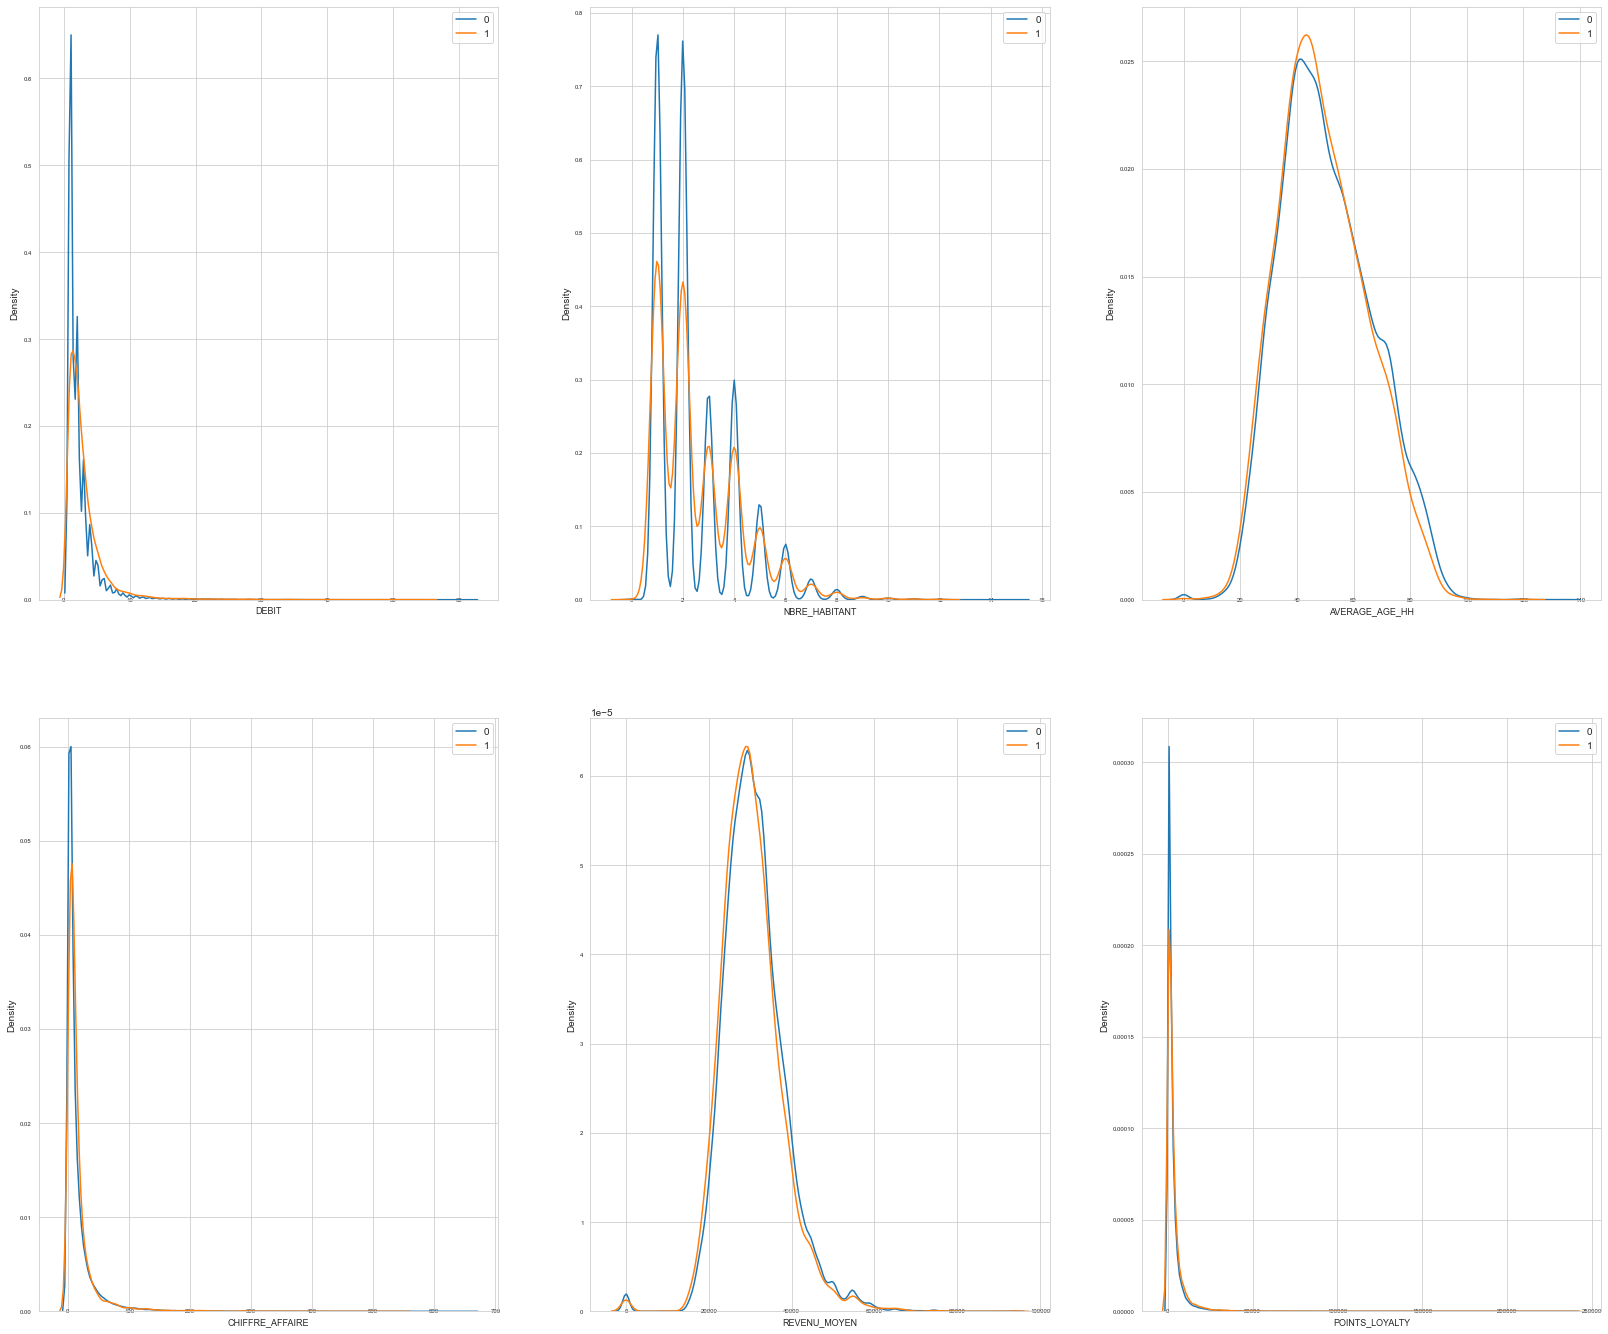

Wall time: 8.76 s


In [36]:
%%time
#let's now look at how  the features relate to the target variable

t0 = hh_df.loc[(hh_df['bought_c'] == 0)]
t1 = hh_df.loc[(hh_df['bought_c'] == 1)]
features = dups[(dups['Type'] != 'object') & (dups['Feature'] != 'HH_ID')]['Feature']
plot_feature_distribution(t0, t1, '0', '1', features)

<AxesSubplot:xlabel='D_C'>

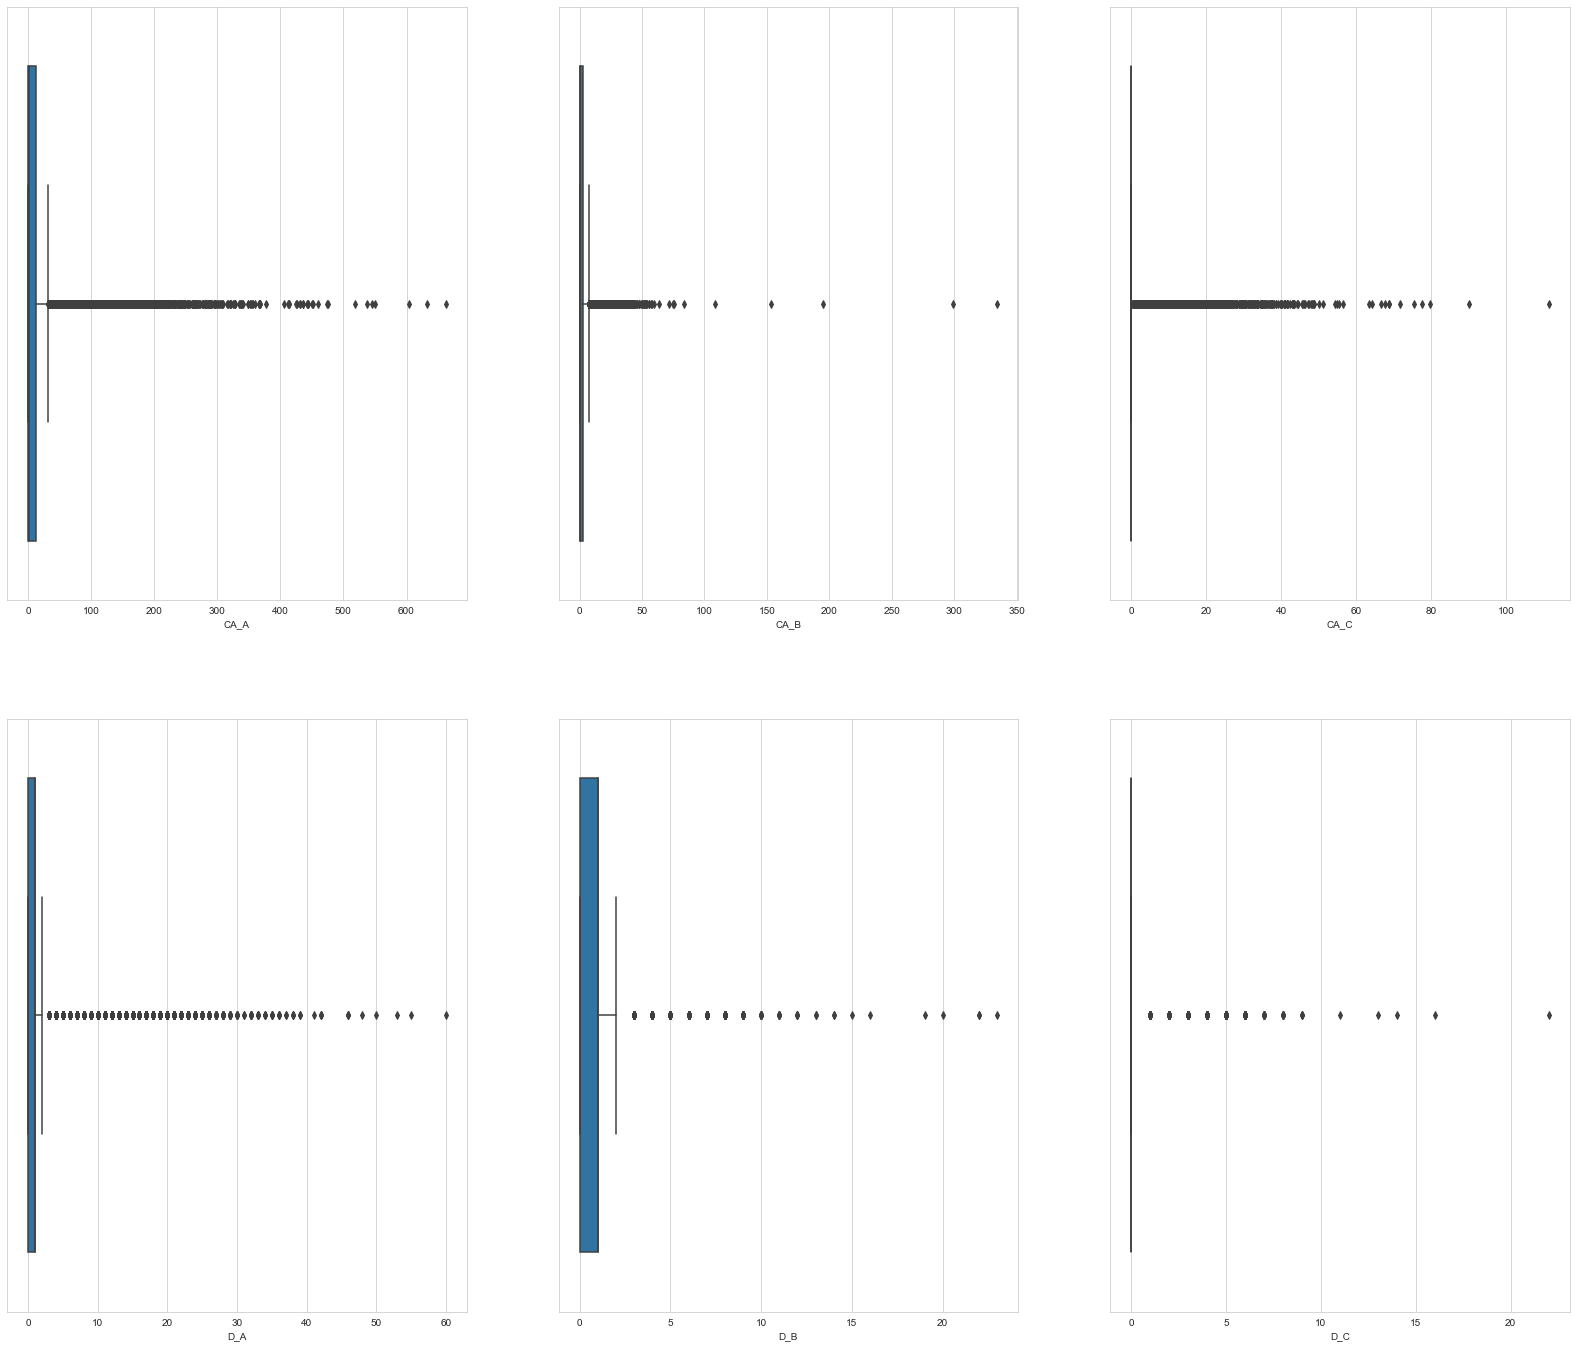

In [37]:
fig, ax = plt.subplots(2,3,figsize=(28,24))
plt.subplot(2,3,1)
sns.boxplot(x=hh_df['CA_A'])
plt.subplot(2,3,2)
sns.boxplot(x=hh_df['CA_B'])
plt.subplot(2,3,3)
sns.boxplot(x=hh_df['CA_C'])
plt.subplot(2,3,4)
sns.boxplot(x=hh_df['D_A'])
plt.subplot(2,3,5)
sns.boxplot(x=hh_df['D_B'])
plt.subplot(2,3,6)
sns.boxplot(x=hh_df['D_C'])

Wall time: 408 ms


[Text(0.5, 0, 'CHIFFRE_AFFAIRE'),
 Text(1.5, 0, 'DEBIT'),
 Text(2.5, 0, 'REVENU_MOYEN'),
 Text(3.5, 0, 'NBRE_HABITANT'),
 Text(4.5, 0, 'POINTS_LOYALTY'),
 Text(5.5, 0, 'AVERAGE_AGE_HH'),
 Text(6.5, 0, 'CA_A'),
 Text(7.5, 0, 'CA_B'),
 Text(8.5, 0, 'CA_C'),
 Text(9.5, 0, 'CA_D'),
 Text(10.5, 0, 'D_A'),
 Text(11.5, 0, 'D_B'),
 Text(12.5, 0, 'D_C'),
 Text(13.5, 0, 'D_D'),
 Text(14.5, 0, 'bought_c'),
 Text(15.5, 0, 'bought_a'),
 Text(16.5, 0, 'bought_b'),
 Text(17.5, 0, 'bought_d')]

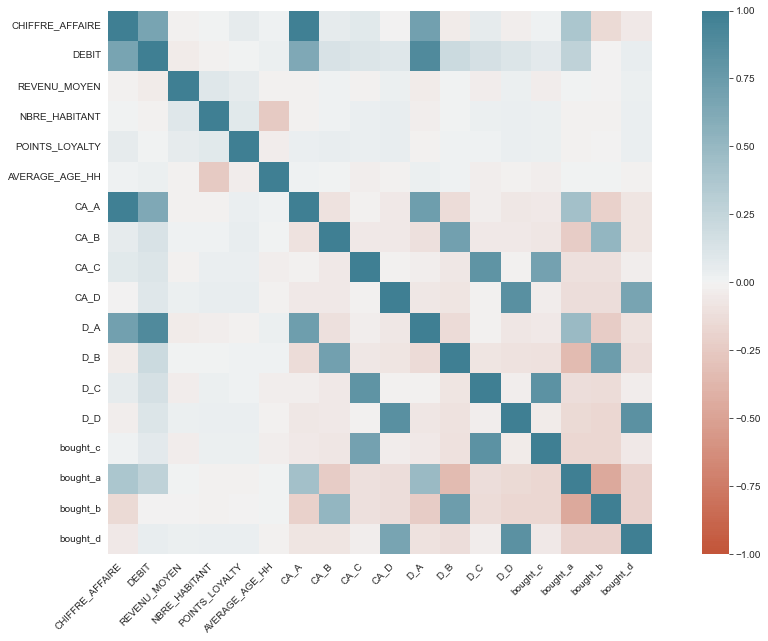

In [38]:
%%time

#between the correlation heatmap here, and the correlations among variables we can see that:
#1) discount correlate negatively to everything (surprise!)
#2) wine correlates to wine (also, surprise), but also to big customers (less of a surprise)
#3) let's keep this in the back of our head for the feature engineering

from matplotlib import rcParams

corr = hh_df.corr()
fig, ax = plt.subplots(figsize=(18,10))    
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The distribution looks at least partially different in all variables, except average revenues
The sales features have quite a few "outliers", so we'll have to deal with them 

# Profiling
Disclaimer: this is done looking at HH with a bonus card, as it was the most reliable way of identifying unique HHs. This is therefore, to the extent HH with loyalty card might not be representative, a biased sample.

looking at quantitative variables, the biggest differences are in:
- loyalty points: the average for product C buyers is higher
- debit: also higher
- avg sales: slightly higher
- among both buyers and non-buyers, the portion buying A and B is similar (but they buy much more A than B or D)
- almost 9k buyers

The "stereotype" product C buyer buys on average for 16.58, of which ~41% comes from C. They have 3.4k loyalty points (very volatile, but more than most others), and they tend to sometimes also buy A or B and (very occasionally) D. They represent ~11% of the customer base and 5% of our sales.

comparing with a and b:
- A has higher average sales (and std) and comaprable frequency (78% of sales)
- B has lower avg sales and std (14% of sales)

A & B look to be substitute products (e.g. HHs either buy one or the other) whereas C seems to be a bit more "standalone".

In [39]:
print('Total sales {:<8.2f}'.format(hh_df['CHIFFRE_AFFAIRE'].sum()))
print('Sales A {:<8.2f}'.format(hh_df['CA_A'].sum()))
print('Sales B {:<8.2f}'.format(hh_df['CA_B'].sum()))
print('Sales C {:<8.2f}'.format(hh_df['CA_C'].sum()))
print('Sales D {:<8.2f}'.format(hh_df['CA_D'].sum()))

Total sales 1261610.53
Sales A 987132.77
Sales B 175158.34
Sales C 60931.20
Sales D 38388.22


In [40]:
print('Sales A {:<8.2f}'.format(hh_df['CA_A'].sum() / hh_df['CHIFFRE_AFFAIRE'].sum()))
print('Sales B {:<8.2f}'.format(hh_df['CA_B'].sum() / hh_df['CHIFFRE_AFFAIRE'].sum()))
print('Sales C {:<8.2f}'.format(hh_df['CA_C'].sum() / hh_df['CHIFFRE_AFFAIRE'].sum()))
print('Sales D {:<8.2f}'.format(hh_df['CA_D'].sum() / hh_df['CHIFFRE_AFFAIRE'].sum()))

Sales A 0.78    
Sales B 0.14    
Sales C 0.05    
Sales D 0.03    


In [41]:
hh_df.describe()

,CHIFFRE_AFFAIRE,DEBIT,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_C,CA_D,D_A,D_B,D_C,D_D,bought_c,bought_a,bought_b,bought_d
count,"82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00"
mean,15.25,2.46,"30,964.70",2.47,"3,008.29",50.51,11.93,2.12,0.74,0.46,1.31,0.78,0.16,0.21,0.11,0.51,0.51,0.14
std,27.01,2.75,"7,424.42",1.58,"5,576.48",16.06,27.04,4.08,3.04,1.67,2.66,1.05,0.57,0.63,0.31,0.50,0.50,0.35
min,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.78,1.00,"26,147.00",1.00,602.00,39.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,6.59,2.00,"30,212.00",2.00,"1,420.00",49.00,0.85,0.59,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
75%,16.05,3.00,"34,884.00",3.00,"3,218.00",62.00,12.94,2.94,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
max,662.35,62.00,"93,770.00",15.00,"240,349.00",135.00,662.35,334.43,111.28,45.31,60.00,23.00,22.00,14.00,1.00,1.00,1.00,1.00


In [42]:
hh_df.loc[(hh_df['bought_c'] == 0)].describe()

,CHIFFRE_AFFAIRE,DEBIT,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_C,CA_D,D_A,D_B,D_C,D_D,bought_c,bought_a,bought_b,bought_d
count,"73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00","73,752.00"
mean,15.09,2.39,"31,048.83",2.46,"2,961.88",50.66,12.38,2.22,0.00,0.48,1.35,0.81,0.00,0.22,0.00,0.53,0.53,0.15
std,26.86,2.67,"7,432.07",1.57,"5,482.97",16.13,27.05,4.16,0.00,1.70,2.64,1.06,0.00,0.64,0.00,0.50,0.50,0.36
min,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.61,1.00,"26,216.00",1.00,598.00,39.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,6.31,2.00,"30,307.00",2.00,"1,400.00",49.00,1.75,0.99,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
75%,15.90,3.00,"34,993.00",3.00,"3,171.00",62.00,13.65,3.03,0.00,0.00,2.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
max,662.35,62.00,"93,770.00",15.00,"240,349.00",135.00,662.35,334.43,0.00,45.31,60.00,23.00,0.00,14.00,0.00,1.00,1.00,1.00


In [43]:
hh_df.loc[(hh_df['bought_c'] == 1)].describe()

,CHIFFRE_AFFAIRE,DEBIT,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_C,CA_D,D_A,D_B,D_C,D_D,bought_c,bought_a,bought_b,bought_d
count,"8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00"
mean,16.58,3.05,"30,273.41",2.60,"3,389.64",49.27,8.24,1.25,6.79,0.31,0.94,0.46,1.51,0.14,1.00,0.28,0.28,0.09
std,28.13,3.32,"7,325.18",1.64,"6,279.90",15.41,26.74,3.16,6.65,1.47,2.82,0.95,0.98,0.54,0.00,0.45,0.45,0.29
min,0.50,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
25%,4.34,1.00,"25,460.00",1.00,644.50,38.00,0.00,0.00,2.83,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
50%,8.48,2.00,"29,617.00",2.00,"1,590.00",47.00,0.00,0.00,4.73,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
75%,16.79,4.00,"34,070.00",4.00,"3,686.00",60.00,2.76,1.12,8.58,0.00,1.00,1.00,2.00,0.00,1.00,1.00,1.00,0.00
max,546.47,55.00,"93,770.00",12.00,"240,349.00",120.00,537.17,58.13,111.28,35.53,48.00,15.00,22.00,10.00,1.00,1.00,1.00,1.00


In [44]:
hh_df.loc[(hh_df['bought_a'] == 1)].describe()

,CHIFFRE_AFFAIRE,DEBIT,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_C,CA_D,D_A,D_B,D_C,D_D,bought_c,bought_a,bought_b,bought_d
count,"41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00","41,914.00"
mean,25.36,3.21,"30,977.22",2.45,"2,905.27",50.63,23.55,1.16,0.40,0.25,2.58,0.42,0.09,0.12,0.06,1.00,0.28,0.08
std,34.64,3.53,"7,442.10",1.57,"5,261.39",16.11,34.20,2.99,2.27,1.26,3.27,0.86,0.43,0.48,0.24,0.00,0.45,0.27
min,0.20,1.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
25%,6.99,1.00,"26,126.00",1.00,592.00,39.00,5.89,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
50%,14.34,2.00,"30,237.00",2.00,"1,383.00",49.00,12.64,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
75%,29.31,4.00,"34,906.00",3.00,"3,148.00",62.00,27.07,1.11,0.00,0.00,3.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
max,662.35,62.00,"93,770.00",15.00,"168,989.00",133.00,662.35,84.00,90.00,39.87,60.00,16.00,16.00,9.00,1.00,1.00,1.00,1.00


In [45]:
hh_df.loc[(hh_df['bought_b'] == 1)].describe()

,CHIFFRE_AFFAIRE,DEBIT,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_C,CA_D,D_A,D_B,D_C,D_D,bought_c,bought_a,bought_b,bought_d
count,"41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00","41,889.00"
mean,11.23,2.44,"30,931.46",2.46,"2,987.17",50.62,6.40,4.18,0.40,0.25,0.71,1.53,0.09,0.12,0.06,0.28,1.00,0.08
std,21.37,2.49,"7,365.74",1.58,"5,666.34",16.13,20.41,4.92,2.27,1.23,2.07,1.01,0.43,0.47,0.24,0.45,0.00,0.27
min,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,2.21,1.00,"26,126.00",1.00,598.00,39.00,0.00,1.65,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,4.83,2.00,"30,185.00",2.00,"1,397.00",49.00,0.00,2.87,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
75%,11.19,3.00,"34,843.00",3.00,"3,171.00",62.00,2.67,5.12,0.00,0.00,1.00,2.00,0.00,0.00,0.00,1.00,1.00,0.00
max,617.72,62.00,"93,770.00",15.00,"240,349.00",135.00,604.47,334.43,111.28,45.31,60.00,23.00,16.00,8.00,1.00,1.00,1.00,1.00


In [46]:
quarts_count = hh_df.pivot_table(index='QUARTIER', values='bought_c', aggfunc='count').sort_values(by='bought_c', ascending=False)
quarts_penetration = hh_df.pivot_table(index='QUARTIER', values='bought_c').sort_values(by='bought_c', ascending=False)
quarts = quarts_penetration.merge(quarts_count, left_index=True, right_index=True).rename(columns={'bought_c_x':'penetration', 'bought_c_y':'size'})

In [47]:
#the quartier variable seems to be quite interesting, but there is a "sample size" issue for certain quarters
#let's, nevertheless, keep this in mind for the feature engineering
quarts[quarts['size'] > 50].head(10)

,penetration,size
QUARTIER,,
92094B50-,0.22,58
55040A02-,0.22,55
57081A601,0.20,51
11001A052,0.18,60
11002U00-,0.18,78
63072A00-,0.18,67
56011A10-,0.17,59
11008A020,0.17,54
11013A142,0.16,55


# Feature engineering

We have made a profile of product C customers, so that now we have an idea of who they are in relation to available features and compared to other products.

To build a predictive model, a prerequisite task is feature engineering, or to work with available features to make them as effective as possible with regards to a model's predictive power. To an extent, we already performed a bit of wrangling and cleaning (e.g. with NAs) as well as putting the data in the format we need it (one row = one customer).

To begin, let's build a "baseline model" to use as benchmark.

In [48]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#we have to remove total sales & debit, else we cheat

hh_df_baseline = hh_df.drop(columns=['QUARTIER', 'CHIFFRE_AFFAIRE', 'DEBIT', 'CA_C', 'D_C'])

X_train, X_test, y_train, y_test = train_test_split(hh_df_baseline.drop(columns=['bought_c']), 
                                                    hh_df_baseline['bought_c'], test_size=0.3, random_state=42)


sc = StandardScaler()
X_train = pd.DataFrame(data=sc.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=sc.transform(X_test), columns=X_train.columns)

clf = LogisticRegression(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train) 
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)
y_pred_t = clf.predict(X_test)

print(classification_report(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88     51578
           1       0.30      0.59      0.40      6330

    accuracy                           0.80     57908
   macro avg       0.62      0.71      0.64     57908
weighted avg       0.87      0.80      0.83     57908

0.7114771002516043
Wall time: 1.52 s


In [49]:
print(classification_report(y_test, y_pred_t))
print(sklearn.metrics.roc_auc_score(y_test, y_pred_t))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88     22174
           1       0.30      0.59      0.39      2645

    accuracy                           0.81     24819
   macro avg       0.62      0.71      0.64     24819
weighted avg       0.88      0.81      0.83     24819

0.7113695291561516


In [50]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
coefficients.columns = ['Var', 'Coef']
coefficients.sort_values(by='Coef', ascending=False)

,Var,Coef
7,D_A,0.16
8,D_B,0.15
1,NBRE_HABITANT,0.08
2,POINTS_LOYALTY,0.06
9,D_D,0.04
6,CA_D,0.01
5,CA_B,0.01
4,CA_A,0.00
3,AVERAGE_AGE_HH,-0.07
0,REVENU_MOYEN,-0.10


In [51]:
#let's use an efficient way of creating a geography variable from a field with way too many values
#source: https://www.oreilly.com/library/view/practical-statistics-for/9781491952955/

hh_df_qg = hh_df.copy()

quartier_groups = pd.DataFrame([
*pd.DataFrame({
'QUARTIER': hh_df['QUARTIER'],
'sales' : hh_df['CHIFFRE_AFFAIRE'],
})
.groupby(['QUARTIER'])
.apply(lambda x: {
'QUARTIER': x.iloc[0,0],
'count': len(x),
'median_sales': x.sales.median()
})
]).sort_values('median_sales')
quartier_groups['cum_count'] = np.cumsum(quartier_groups['count'])
quartier_groups['quartierGroup'] = pd.qcut(quartier_groups['cum_count'], 5, labels=False,
retbins=False)
to_join = quartier_groups[['QUARTIER', 'quartierGroup']].set_index('QUARTIER')
hh_df_qg = hh_df_qg.join(to_join, on='QUARTIER', how='left')
hh_df_qg['quartierGroup'] = pd.to_numeric(hh_df_qg['quartierGroup'])
hh_df_qg.groupby(by='quartierGroup')['CHIFFRE_AFFAIRE'].mean()

hh_df_quartierGroup = hh_df_qg[['quartierGroup']].drop_duplicates()


hh_df_qg = hh_df_qg.drop(['QUARTIER'], axis=1)

In [52]:
#this already slightly improved our baseline
hh_df_baseline = hh_df_qg.drop(columns=['CHIFFRE_AFFAIRE', 'DEBIT', 'CA_C', 'D_C'])

X_train, X_test, y_train, y_test = train_test_split(hh_df_baseline.drop(columns=['bought_c']), 
                                                    hh_df_baseline['bought_c'], test_size=0.3, random_state=42)


sc = StandardScaler()
X_train = pd.DataFrame(data=sc.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=sc.transform(X_test), columns=X_train.columns)

clf = LogisticRegression(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train) 
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)
y_pred_t = clf.predict(X_test)

print(classification_report(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.85     51578
           1       0.26      0.65      0.37      6330

    accuracy                           0.76     57908
   macro avg       0.61      0.71      0.61     57908
weighted avg       0.87      0.76      0.80     57908

0.7123794805297115


In [53]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
coefficients.columns = ['Var', 'Coef']
coefficients.sort_values(by='Coef', ascending=False)

,Var,Coef
13,quartierGroup,0.26
7,D_A,0.17
8,D_B,0.15
1,NBRE_HABITANT,0.08
2,POINTS_LOYALTY,0.06
9,D_D,0.04
6,CA_D,0.00
5,CA_B,-0.02
4,CA_A,-0.02
3,AVERAGE_AGE_HH,-0.07


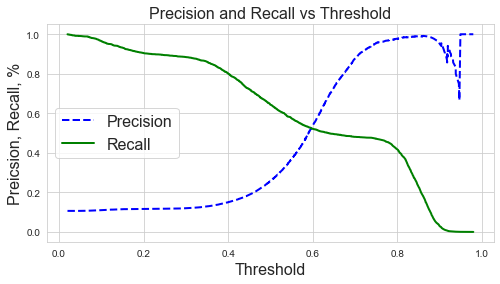

In [54]:
#fine-tuning the precision / recall threshold, we can get as high as almost 60% on both
#not great, not terrible for a first baseline model

from sklearn.metrics import precision_recall_curve

preds = clf.predict_proba(X_test)[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_test, preds)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                              
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                     
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [55]:
X_train.columns

Index(['REVENU_MOYEN', 'NBRE_HABITANT', 'POINTS_LOYALTY', 'AVERAGE_AGE_HH',
       'CA_A', 'CA_B', 'CA_D', 'D_A', 'D_B', 'D_D', 'bought_a', 'bought_b',
       'bought_d', 'quartierGroup'],
      dtype='object')

Let's now deal with outliers. We have seen there are quite a few. Options include removing, keeping or transforming
We can use the winsorization trasformation to limit extreme values without removing them. This can be applied to quantitative features.


In [56]:
wins_cols = ['CA_A', 'CA_B', 'CA_D', 'D_A', 'D_B', 'D_D', 'REVENU_MOYEN', 'NBRE_HABITANT',
       'POINTS_LOYALTY', 'AVERAGE_AGE_HH']

modeling_df = hh_df_qg.copy()

#winsorize outliers
winsorizer = FunctionTransformer(scipy.stats.mstats.winsorize, kw_args={'axis': 0, 'inplace': False, 'limits': [0, 0.01]})

#winsorize does not work in pipeline, so let's apply it more traditionally
for col in wins_cols:
    modeling_df[col] = scipy.stats.mstats.winsorize(a=modeling_df[col], limits=0.005, inplace=True)

In [57]:
#no bad value for average age
modeling_df[modeling_df['AVERAGE_AGE_HH'] == 0]

,CHIFFRE_AFFAIRE,DEBIT,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_C,CA_D,D_A,D_B,D_C,D_D,bought_c,bought_a,bought_b,bought_d,quartierGroup
HH_ID,,,,,,,,,,,,,,,,,,,


# Feature engineering summary

At this stage we have dealt with outliers and categorical variables.
We created a new feature to combine quartiers data, so basically lumping together the quartiers in bins on the basis of median sales.
Given more time, we could have done additional processing (e.g. created new features, combined existing ones, clustered our data...), but given available time, we have to make do.

Let's now move on to the
# Modeling

In this part we will build and test a model. Let's jump into it and deploy a LGBM

In [58]:
test_id = modeling_df.sample(frac = 0.1).index
modeling_df_train = modeling_df[~modeling_df.index.isin(test_id)].drop(columns=['CHIFFRE_AFFAIRE', 'DEBIT', 'CA_C', 'D_C'])
modeling_df_test = modeling_df[modeling_df.index.isin(test_id)].drop(columns=['CHIFFRE_AFFAIRE', 'DEBIT', 'CA_C', 'D_C'])

In [59]:
modeling_df_test

,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_D,D_A,D_B,D_D,bought_c,bought_a,bought_b,bought_d,quartierGroup
HH_ID,,,,,,,,,,,,,,,
150,"24,650.00",4,220,44,7.37,0.00,0.00,2.00,0.00,0.00,0,1,0,0,2
738,"25,606.00",4,5648,44,0.00,3.38,0.89,0.00,1.00,1.00,0,0,1,1,2
1328,"30,912.00",2,3066,44,0.00,1.55,0.00,0.00,1.00,0.00,0,0,1,0,1
1619,"26,617.00",2,3423,43,36.31,0.00,0.00,3.00,0.00,0.00,0,1,0,0,0
2347,"57,102.00",2,2861,51,0.00,11.06,0.00,0.00,5.00,0.00,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6490279482,"24,794.00",1,646,70,0.00,0.00,1.58,0.00,0.00,1.00,0,0,0,1,2
6490798722,"31,996.00",1,386,25,0.00,0.00,8.70,0.00,0.00,3.00,0,0,0,1,1
6490899654,"28,745.00",1,1447,30,0.00,3.27,0.00,0.00,1.00,0.00,0,0,1,0,2


In [60]:
%%time
#stolen with pride from here: https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997
#and https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
#baseline lgbm, leaving last ~8k records as holdout sample, to make sure we have a "clean" test set

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import time

N_SPLITS = 5
strat_kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

modeling_df_prepared_lgb = modeling_df_train

X = modeling_df_prepared_lgb.drop(columns=['bought_c']).reset_index().drop(columns=['HH_ID'])
y = modeling_df_prepared_lgb.reset_index().drop(columns=['HH_ID'])['bought_c']

    
scores = np.empty(N_SPLITS)
for idx, (train_idx, test_idx) in enumerate(strat_kf.split(X, y)):
    print("=" * 12 + f"Training fold {idx}" + 12 * "=")
    start = time.time()

    X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    eval_set = [(X_val, y_val)]

    lgbm_clf = lgbm.LGBMClassifier(n_estimators=10000, n_jobs=4)
    lgbm_clf.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric="binary_logloss",
        callbacks=[lgbm.early_stopping(1000), lgbm.log_evaluation(1000)]
    )

    preds = lgbm_clf.predict_proba(X_val)
    loss = log_loss(y_val, preds)
    scores[idx] = loss
    runtime = time.time() - start
    print(f"Fold {idx} finished with score: {loss:.5f} in {runtime:.2f} seconds.\n")

============Training fold 0============
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's binary_logloss: 0.232625
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.209889
Fold 0 finished with score: 0.20989 in 4.86 seconds.

============Training fold 1============
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's binary_logloss: 0.234756
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.211257
Fold 1 finished with score: 0.21126 in 4.11 seconds.

============Training fold 2============
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's binary_logloss: 0.236337
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.212975
Fold 2 finished with score: 0.21298 in 3.87 seconds.

============Training fold 3============
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's binary_logloss: 0.236586
Early stopping, best iteration is

In [61]:
preds_test1 = lgbm_clf.predict(modeling_df_test.drop(columns=['bought_c']).reset_index().drop(columns=['HH_ID']))
y_test = modeling_df_test.reset_index().drop(columns=['HH_ID'])['bought_c']

In [62]:
#basic LGBM not ideal to the task, let's run a grid search
print(classification_report(y_test, preds_test1))
print(sklearn.metrics.roc_auc_score(y_test, preds_test1))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7382
           1       1.00      0.46      0.63       891

    accuracy                           0.94      8273
   macro avg       0.97      0.73      0.80      8273
weighted avg       0.95      0.94      0.93      8273

0.7283950617283951


In [63]:
%%time
import optuna
from optuna.integration import LightGBMPruningCallback
from warnings import simplefilter

def objective(trial, X, y):
    param_grid = {
#        "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart', 'rf']),
        "n_estimators": trial.suggest_int("n_estimators",1000, 15000, step=1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 50, step=2),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "reg_alpha": trial.suggest_int("lambda_l1", 0, 15, step=5),
        "reg_lambda": trial.suggest_int("lambda_l2", 0, 15, step=5),
        "class_weight": trial.suggest_categorical("class_weight", ['balanced', None]),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.7, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.7, 0.9, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", silent=True, n_jobs=4, **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss"),
                lgbm.log_evaluation(0),
                lgbm.early_stopping(200)
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test, n_jobs=4)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)


study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)

simplefilter("ignore", category=UserWarning)

#here we show 2 for simplicity, but below the result for 50
study.optimize(func, n_trials=2)

[I 2022-03-29 08:59:42,062] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] min_gain_to_split is set=7.101346372953585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.101346372953585
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[357]	valid_0's binary_logloss: 0.445589
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] min_gain_to_split is set=7.101346372953585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.101346372953585
[LightGBM] [Warning] bagg

[I 2022-03-29 08:59:50,926] Trial 0 finished with value: 0.44477879073790155 and parameters: {'boosting_type': 'rf', 'n_estimators': 14000, 'learning_rate': 0.21859533595157027, 'num_leaves': 16, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 10, 'class_weight': 'balanced', 'min_gain_to_split': 7.101346372953585, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.44477879073790155.


Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.446391
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] min_gain_to_split is set=4.700771627239649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.700771627239649
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.212619
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] min_gain_to_split is set=4.700771627239649, min_split_gain=0.0 will be ignored. 

[I 2022-03-29 09:00:00,046] Trial 1 finished with value: 0.21599664670367727 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 10000, 'learning_rate': 0.08426365828282609, 'num_leaves': 50, 'max_depth': 13, 'lambda_l1': 5, 'lambda_l2': 5, 'class_weight': None, 'min_gain_to_split': 4.700771627239649, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.21599664670367727.


Early stopping, best iteration is:
[452]	valid_0's binary_logloss: 0.220525
Wall time: 19 s


In [64]:
modeling_df_test.drop(columns=['bought_c']).reset_index().drop(columns=['HH_ID'])

,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_D,D_A,D_B,D_D,bought_a,bought_b,bought_d,quartierGroup
0,"24,650.00",4,220,44,7.37,0.00,0.00,2.00,0.00,0.00,1,0,0,2
1,"25,606.00",4,5648,44,0.00,3.38,0.89,0.00,1.00,1.00,0,1,1,2
2,"30,912.00",2,3066,44,0.00,1.55,0.00,0.00,1.00,0.00,0,1,0,1
3,"26,617.00",2,3423,43,36.31,0.00,0.00,3.00,0.00,0.00,1,0,0,0
4,"57,102.00",2,2861,51,0.00,11.06,0.00,0.00,5.00,0.00,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8268,"24,794.00",1,646,70,0.00,0.00,1.58,0.00,0.00,1.00,0,0,1,2
8269,"31,996.00",1,386,25,0.00,0.00,8.70,0.00,0.00,3.00,0,0,1,1
8270,"28,745.00",1,1447,30,0.00,3.27,0.00,0.00,1.00,0.00,0,1,0,2
8271,"42,640.00",1,327,29,0.00,0.99,0.00,0.00,1.00,0.00,0,1,0,2


In [65]:
print(f"\tBest value (logloss): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}") 
    



	Best value (logloss): 0.21600
	Best params:
		boosting_type: gbdt
		n_estimators: 10000
		learning_rate: 0.08426365828282609
		num_leaves: 50
		max_depth: 13
		lambda_l1: 5
		lambda_l2: 5
		class_weight: None
		min_gain_to_split: 4.700771627239649
		bagging_fraction: 0.7
		bagging_freq: 1
		feature_fraction: 0.8999999999999999


In [66]:
lgbm_best = lgbm.LGBMClassifier(objective="binary", 
        boosting_type= 'gbdt',
		n_estimators= 9000,
		learning_rate= 0.2238000353543344,
		num_leaves= 16,
		max_depth= 6,
		lambda_l1= 0,
		lambda_l2= 15,
		class_weight= None,
		min_gain_to_split= 0.8127341064994592,
		bagging_fraction= 0.7,
		bagging_freq=1,
		feature_fraction= 0.7999999999999999)

lgbm_best.fit(modeling_df_train.drop(columns=['bought_c']).reset_index().drop(columns=['HH_ID']), modeling_df_train['bought_c'])

[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] min_gain_to_split is set=0.8127341064994592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8127341064994592
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.7, bagging_freq=1,
               feature_fraction=0.7999999999999999, lambda_l1=0, lambda_l2=15,
               learning_rate=0.2238000353543344, max_depth=6,
               min_gain_to_split=0.8127341064994592, n_estimators=9000,
               num_leaves=16, objective='binary')

In [67]:
#test new model on full training data
preds_best = (lgbm_best.predict(modeling_df_train.drop(columns=['bought_c']).reset_index().drop(columns=['HH_ID'])))

print("ROC AUC score: {:<8.5f}".format(roc_auc_score(preds_best, modeling_df_train['bought_c'])))

print(classification_report(modeling_df_train['bought_c'], preds_best))

ROC AUC score: 0.97544 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     66370
           1       1.00      0.59      0.74      8084

    accuracy                           0.96     74454
   macro avg       0.98      0.79      0.86     74454
weighted avg       0.96      0.96      0.95     74454



In [68]:
#test new model on test data
preds_best = (lgbm_best.predict(modeling_df_test.drop(columns=['bought_c']).reset_index().drop(columns=['HH_ID'])))

print("ROC AUC score: {:<8.5f}".format(roc_auc_score(preds_best, modeling_df_test['bought_c'])))

print(classification_report(modeling_df_test['bought_c'], preds_best))

ROC AUC score: 0.92279 
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      7382
           1       0.91      0.46      0.61       891

    accuracy                           0.94      8273
   macro avg       0.92      0.73      0.79      8273
weighted avg       0.94      0.94      0.93      8273



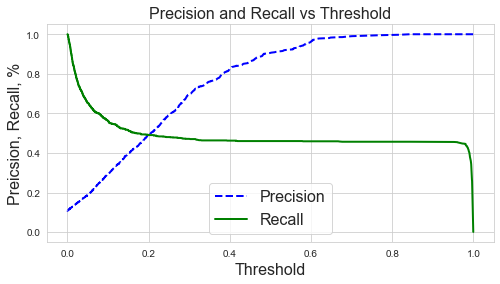

In [69]:
#our LGBM model, after an intense grid search, provides very high precision, but not ideal recall
#this is not perfect, but given the time constraints it could have been much worse
#and, for many marketing applications, precision tends to be more important than recall
#where the cost of a false positive is higher than the cost of a false negative

from sklearn.metrics import precision_recall_curve

preds = lgbm_best.predict_proba(modeling_df_test.drop(columns=['bought_c']).reset_index().drop(columns=['HH_ID']))[:,1]

precisions, recalls, thresholds = precision_recall_curve(modeling_df_test['bought_c'], preds)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                              
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                     
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [70]:
#very high precision, low recall
#fine-tuning the precision/recall threshold should be done with the business or a domain expert, to know which to prioritize
#were recall to be highly important, further feature engineering steps would be necessary

y_pred_t = lgbm_best.predict_proba(modeling_df_test.drop(columns=['bought_c']).reset_index().drop(columns=['HH_ID']))
thresh = 0.8
pred_2 = []

for x in y_pred_t:
    if x[1] >= thresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(modeling_df_test['bought_c'], pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7382
           1       1.00      0.46      0.63       891

    accuracy                           0.94      8273
   macro avg       0.97      0.73      0.80      8273
weighted avg       0.94      0.94      0.93      8273

408


In [71]:
y_pred_t = lgbm_best.predict_proba(modeling_df.drop(columns=['bought_c', 'CA_C', 'D_C', 'CHIFFRE_AFFAIRE', 'DEBIT']).reset_index().drop(columns=['HH_ID']))
thresh = 0.8
pred_2 = []

for x in y_pred_t:
    if x[1] >= thresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(modeling_df['bought_c'], pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     73752
           1       1.00      0.48      0.65      8975

    accuracy                           0.94     82727
   macro avg       0.97      0.74      0.81     82727
weighted avg       0.95      0.94      0.93     82727

4282


In [72]:
modeling_df['bought_c'].value_counts()

0    73752
1     8975
Name: bought_c, dtype: int64

In [73]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(modeling_df['bought_c'], pred_2))


[[73751     1]
 [ 4694  4281]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

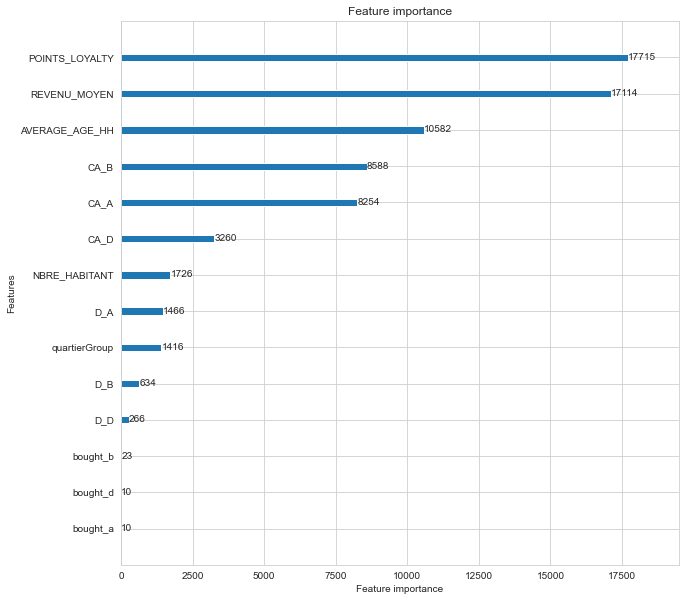

In [74]:
lgbm.plot_importance(lgbm_best, figsize=(10,10))

In [75]:
modeling_df['bought_c_pred'] = pred_2

In [76]:
modeling_df.describe()

,CHIFFRE_AFFAIRE,DEBIT,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_C,CA_D,D_A,D_B,D_C,D_D,bought_c,bought_a,bought_b,bought_d,quartierGroup,bought_c_pred
count,"82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00","82,727.00"
mean,15.25,2.46,"30,998.66",2.47,"2,914.97",50.51,11.58,2.07,0.74,0.44,1.28,0.77,0.16,0.21,0.11,0.51,0.51,0.14,1.89,0.05
std,27.01,2.75,"7,106.29",1.55,"4,520.29",15.93,23.72,3.33,3.04,1.41,2.38,0.99,0.57,0.60,0.31,0.50,0.50,0.35,1.14,0.22
min,0.02,1.00,"15,644.00",1.00,50.00,19.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.78,1.00,"26,147.00",1.00,602.00,39.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,6.59,2.00,"30,212.00",2.00,"1,420.00",49.00,0.85,0.59,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,2.00,0.00
75%,16.05,3.00,"34,884.00",3.00,"3,218.00",62.00,12.94,2.94,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,3.00,0.00
max,662.35,62.00,"57,102.00",8.00,"34,608.00",90.00,170.10,20.93,111.28,10.47,18.00,5.00,22.00,4.00,1.00,1.00,1.00,1.00,4.00,1.00


In [77]:
modeling_df[modeling_df['bought_c'] == 1].describe()

,CHIFFRE_AFFAIRE,DEBIT,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_C,CA_D,D_A,D_B,D_C,D_D,bought_c,bought_a,bought_b,bought_d,quartierGroup,bought_c_pred
count,"8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00","8,975.00"
mean,16.58,3.05,"30,305.07",2.59,"3,273.37",49.28,7.83,1.21,6.79,0.29,0.90,0.45,1.51,0.14,1.00,0.28,0.28,0.09,1.99,0.48
std,28.13,3.32,"7,000.47",1.61,"4,912.20",15.32,22.81,2.85,6.65,1.17,2.42,0.90,0.98,0.51,0.00,0.45,0.45,0.29,1.11,0.50
min,0.50,1.00,"15,644.00",1.00,50.00,19.00,0.00,0.00,0.21,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,4.34,1.00,"25,460.00",1.00,644.50,38.00,0.00,0.00,2.83,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
50%,8.48,2.00,"29,617.00",2.00,"1,590.00",47.00,0.00,0.00,4.73,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00
75%,16.79,4.00,"34,070.00",4.00,"3,686.00",60.00,2.76,1.12,8.58,0.00,1.00,1.00,2.00,0.00,1.00,1.00,1.00,0.00,3.00,1.00
max,546.47,55.00,"57,102.00",8.00,"34,608.00",90.00,170.10,20.93,111.28,10.47,18.00,5.00,22.00,4.00,1.00,1.00,1.00,1.00,4.00,1.00


In [78]:
modeling_df[modeling_df['bought_c_pred'] == 1].describe()

,CHIFFRE_AFFAIRE,DEBIT,REVENU_MOYEN,NBRE_HABITANT,POINTS_LOYALTY,AVERAGE_AGE_HH,CA_A,CA_B,CA_C,CA_D,D_A,D_B,D_C,D_D,bought_c,bought_a,bought_b,bought_d,quartierGroup,bought_c_pred
count,"4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00","4,282.00"
mean,7.59,1.63,"30,305.58",2.56,"3,286.38",49.30,0.71,0.06,6.76,0.02,0.08,0.02,1.51,0.01,1.00,0.01,0.01,0.00,1.80,1.00
std,12.38,1.76,"7,041.25",1.59,"4,903.70",15.33,9.11,0.76,6.58,0.35,1.01,0.26,0.97,0.13,0.02,0.10,0.10,0.07,1.08,0.00
min,0.50,1.00,"15,644.00",1.00,50.00,19.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,2.76,1.00,"25,398.25",1.00,632.00,38.00,0.00,0.00,2.76,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00
50%,4.77,1.00,"29,672.50",2.00,"1,569.50",47.00,0.00,0.00,4.71,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,2.00,1.00
75%,8.58,2.00,"34,085.00",4.00,"3,722.00",60.00,0.00,0.00,8.50,0.00,0.00,0.00,2.00,0.00,1.00,0.00,0.00,0.00,3.00,1.00
max,243.98,51.00,"57,102.00",8.00,"34,608.00",90.00,170.10,20.10,79.66,10.47,18.00,5.00,22.00,4.00,1.00,1.00,1.00,1.00,4.00,1.00


In [79]:
modeling_df[modeling_df['bought_c'] == 1]['quartierGroup'].value_counts() / modeling_df[modeling_df['bought_c'] == 1].shape[0]

2   0.33
1   0.26
3   0.23
4   0.10
0   0.09
Name: quartierGroup, dtype: float64

In [80]:
modeling_df[modeling_df['bought_c_pred'] == 1]['quartierGroup'].value_counts() / modeling_df[modeling_df['bought_c_pred'] == 1].shape[0]

2   0.33
1   0.30
3   0.19
0   0.11
4   0.06
Name: quartierGroup, dtype: float64

In [81]:
quartier_groups

,QUARTIER,count,median_sales,cum_count,quartierGroup
11806,92137A22-,2,0.21,2,0
6909,53053A812,1,0.53,3,0
11309,91114L30-,1,0.55,4,0
11212,91034Z999,1,0.59,5,0
8064,61039A400,1,0.59,6,0
...,...,...,...,...,...
6730,52074B0PN,1,294.94,82722,4
7657,56086E0PP,1,299.21,82723,4
10579,82032A020,2,322.04,82725,4
9123,63046A09-,1,332.62,82726,4


In [82]:
modeling_df[modeling_df['bought_c_pred'] == 1].shape

(4282, 20)

In [83]:
modeling_df[(modeling_df['bought_c_pred'] == 1) & (modeling_df['bought_b'] == 1)].shape

(41, 20)

In [84]:
modeling_df[modeling_df['bought_c'] == 1].shape

(8975, 20)

In [85]:
modeling_df[(modeling_df['bought_c'] == 1) & (modeling_df['bought_b'] == 1)].shape

(2484, 20)

In [86]:
#save predictions & actuals
modeling_df[['bought_c', 'bought_c_pred']].to_csv(os.path.join(output,r'case_preds.csv'))